### Imports and configuration

In [24]:
import pandas as pd
import numpy as np
from os.path import join as opj
from collections import defaultdict, Counter

import sys
sys.path.append('/home/isabrah/sustainable_high_quality_wikis')
from modeling.modeling_utils import find_optimal_threshold, eval_classification_preds
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from tqdm import tqdm

In [25]:
def generate_agg_features_per_article(events_df):
    fa_fail_status = {'demoted', 'failed', 'removed'}
    fa_success_status = {'kept', 'pass'}
    ga_fail_status = {'delisted', 'failed', 'not listed', 'fail'}
    ga_success_status = {'kept', 'listed', 'keep', 'passed', }
    reviews_info_list = list()
    for row_idx, row_content in events_df.iterrows():
        if row_content['action'] == 'far' and str(row_content['result']) in fa_fail_status:
            reviews_info_list.append({'page_id': row_content['page_id'], 'date': row_content['date'], 'action': 'far', 'result': 0})
            continue
        elif row_content['action'] == 'far' and str(row_content['result']) in fa_success_status:
            reviews_info_list.append({'page_id': row_content['page_id'], 'date': row_content['date'], 'action': 'far', 'result': 1})
            continue
        elif row_content['action'] == 'gar' and str(row_content['result']) in ga_fail_status:
            reviews_info_list.append({'page_id': row_content['page_id'], 'date': row_content['date'], 'action': 'gar', 'result': 0})
            continue
        elif row_content['action'] == 'gar' and str(row_content['result']) in ga_success_status:
            reviews_info_list.append({'page_id': row_content['page_id'], 'date': row_content['date'], 'action': 'gar', 'result': 1})
            continue
    # end of the loop
    print(f"We were able to map {len(reviews_info_list)} relevant review events out of {events_df.shape[0]} potential events.")
    reviews_info_df = pd.DataFrame.from_records(reviews_info_list)
    return reviews_info_df

### Configurations and data loading

In [26]:
model_version = 10.2 # 20.2 #use 10.2 for FA and 20.2 for GA 
# BE CAREFUL HERE!
usecase = 'fa' if model_version==10.2 else 'ga'
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
model_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'
data_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/wiki_generated_data/'
metadata_files_folder = opj(data_folder, 'meta_data')
top_x = 100#'all'#'all'#'all'#50 #if set to all, we take ALL false negative or ALL false positive

In [27]:
# load the data to analyze this king of data
events_df = pd.read_csv(opj(metadata_files_folder, 'article_events_from_latest_talkpages.csv'))
reviews_info_df = generate_agg_features_per_article(events_df=events_df)
# now we can aggregate values per 'page_id'
if usecase == 'fa':
    agg_events_per_article = (reviews_info_df[reviews_info_df['action']=='far'].groupby('page_id').
                              agg(num_cases=('result', 'count'), sum_values=('result', 'sum'))).reset_index()   # Sum of values
    agg_events_per_article.set_index(agg_events_per_article['page_id'], inplace=True, drop=False)
elif usecase == 'ga':
    agg_events_per_article = (reviews_info_df[(reviews_info_df['action']=='gar') | (reviews_info_df['action']=='far')].groupby('page_id').
                              agg(num_cases=('result', 'count'), sum_values=('result', 'sum'))).reset_index()   # Sum of values
    agg_events_per_article.set_index(agg_events_per_article['page_id'], inplace=True, drop=False)
else:
    raise IOError("Invalid usecase. Has to be one out of the two: [fa, ga]")
print(f"There are {agg_events_per_article.shape[0]} pages being reviewed. There are {sum(agg_events_per_article['num_cases'])} reviews overall")
agg_events_per_article.head()

We were able to map 6895 relevant review events out of 87285 potential events.
There are 1912 pages being reviewed. There are 2276 reviews overall


,page_id,num_cases,sum_values
page_id,,,
25,25,2,0
307,307,1,0
573,573,1,0
586,586,2,1
663,663,1,1


now, we have a dataframe, with two relevant columns per article - the number of reviews and the number of passes reviews
We can now load the predictions, join it with the agg table and get final measures

In [28]:
row_lvl_preds = pd.read_csv(opj(model_folder, str(model_version), 'row_lvl_preds.csv'))
row_lvl_preds.rename(columns={'Unnamed: 0': 'page_id'}, inplace=True)
row_lvl_preds.set_index(row_lvl_preds.columns[0], inplace=True, drop=False)
row_lvl_preds.shape

(5814, 5)

In [29]:
# to make the analysis complete, we have to add page_ids that are missing in the agg_events_per_article dataframe
# we do it in two steps. First adding the demoted pages according to out dataset, and fill these with 1s
# Second, we add all the other cases and fill those with zeros (these are cases of promoted pages that had no discussion about demotion)
demoted_pages_according_to_modeling_df = set(row_lvl_preds[row_lvl_preds['true_value']==0]['page_id'])
agg_events_per_article = agg_events_per_article.reindex(row_lvl_preds.index)
agg_events_per_article['page_id'] = agg_events_per_article.index.astype(int)
agg_events_per_article.fillna(0, inplace=True)

# now fixing the demoted ones which we were not able to get their talk page (or some other reason)
pages_to_fix = set(agg_events_per_article[(agg_events_per_article['page_id'].isin(demoted_pages_according_to_modeling_df)) & (agg_events_per_article['num_cases']==0)]['page_id'])
agg_events_per_article.loc[agg_events_per_article['page_id'].isin(pages_to_fix), ['num_cases', 'sum_values']] = [1, 1]
print(f"Now, there are {agg_events_per_article.shape[0]} pages being reviewed. There are {sum(agg_events_per_article['num_cases'])} reviews overall")

Now, there are 5814 pages being reviewed. There are 1742.0 reviews overall


In [30]:
# extract the top X false negative (dynamic)
if top_x == 'all':
    false_negative = row_lvl_preds[(row_lvl_preds['true_value']==1) 
                                   & (row_lvl_preds['opt_th_pred']==0)].sort_values(by='pred_proba', ascending=True)
    false_positive = row_lvl_preds[(row_lvl_preds['true_value']==0) 
                                   & (row_lvl_preds['opt_th_pred']==1)].sort_values(by='pred_proba', ascending=True)
    true_positive = row_lvl_preds[(row_lvl_preds['true_value']==1) 
                                  & (row_lvl_preds['opt_th_pred']==1)].sort_values(by='pred_proba', ascending=True)
    true_negative = row_lvl_preds[(row_lvl_preds['true_value']==0) 
                                  & (row_lvl_preds['opt_th_pred']==0)].sort_values(by='pred_proba', ascending=True)
else:
    false_negative = row_lvl_preds[row_lvl_preds['true_value']==1].sort_values(by='pred_proba', ascending=True)[0:top_x]
    false_positive = row_lvl_preds[row_lvl_preds['true_value']==0].sort_values(by='pred_proba', ascending=False)[0:top_x]
    true_negative = row_lvl_preds[row_lvl_preds['true_value']==0].sort_values(by='pred_proba', ascending=True)[0:top_x]
    true_positive = row_lvl_preds[row_lvl_preds['true_value']==1].sort_values(by='pred_proba', ascending=False)[0:top_x]
fn_page_ids = set(false_negative.index)
fp_page_ids = set(false_positive.index)
tn_page_ids = set(true_negative.index)
tp_page_ids = set(true_positive.index)
negative_page_ids = set(row_lvl_preds[row_lvl_preds['true_value']==0]['page_id'])
positive_page_ids = set(row_lvl_preds[row_lvl_preds['true_value']==1]['page_id'])

#### Barplot of the distributions (new way, using only agg numbers)


In [31]:
negative_pages_mean = np.mean(agg_events_per_article[agg_events_per_article['page_id'].isin(negative_page_ids)]['num_cases'])
negative_pages_std = np.std(agg_events_per_article[agg_events_per_article['page_id'].isin(negative_page_ids)]['num_cases'])
negative_pages_n = agg_events_per_article[agg_events_per_article['page_id'].isin(negative_page_ids)].shape[0]

positive_pages_mean = np.mean(agg_events_per_article[agg_events_per_article['page_id'].isin(positive_page_ids)]['num_cases'])
positive_pages_std = np.std(agg_events_per_article[agg_events_per_article['page_id'].isin(positive_page_ids)]['num_cases'])
positive_pages_n = agg_events_per_article[agg_events_per_article['page_id'].isin(positive_page_ids)].shape[0]

In [32]:
false_negatives_mean = np.mean(agg_events_per_article[agg_events_per_article['page_id'].isin(fn_page_ids)]['num_cases'])
false_negatives_std = np.std(agg_events_per_article[agg_events_per_article['page_id'].isin(fn_page_ids)]['num_cases'])
false_negatives_n = agg_events_per_article[agg_events_per_article['page_id'].isin(fn_page_ids)].shape[0]

false_positives_mean = np.mean(agg_events_per_article[agg_events_per_article['page_id'].isin(fp_page_ids)]['num_cases'])
false_positives_std = np.std(agg_events_per_article[agg_events_per_article['page_id'].isin(fp_page_ids)]['num_cases'])
false_positives_n = agg_events_per_article[agg_events_per_article['page_id'].isin(fp_page_ids)].shape[0]

In [33]:
true_negatives_mean = np.mean(agg_events_per_article[agg_events_per_article['page_id'].isin(tn_page_ids)]['num_cases'])
true_negatives_std = np.std(agg_events_per_article[agg_events_per_article['page_id'].isin(tn_page_ids)]['num_cases'])
true_negatives_n = agg_events_per_article[agg_events_per_article['page_id'].isin(tn_page_ids)].shape[0]

true_positives_mean = np.mean(agg_events_per_article[agg_events_per_article['page_id'].isin(tp_page_ids)]['num_cases'])
true_positives_std = np.std(agg_events_per_article[agg_events_per_article['page_id'].isin(tp_page_ids)]['num_cases'])
true_positives_n = agg_events_per_article[agg_events_per_article['page_id'].isin(tp_page_ids)].shape[0]

In [34]:
all_population_mean = np.mean(agg_events_per_article['num_cases'])
all_population_std = np.std(agg_events_per_article['num_cases'])
all_population_n = agg_events_per_article['num_cases'].shape[0]

/tmp/ipykernel_1888738/4184385653.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Unsustainable', 'Wrongly Predicted\nUnsustainable (FP)', 'Sustainable'])


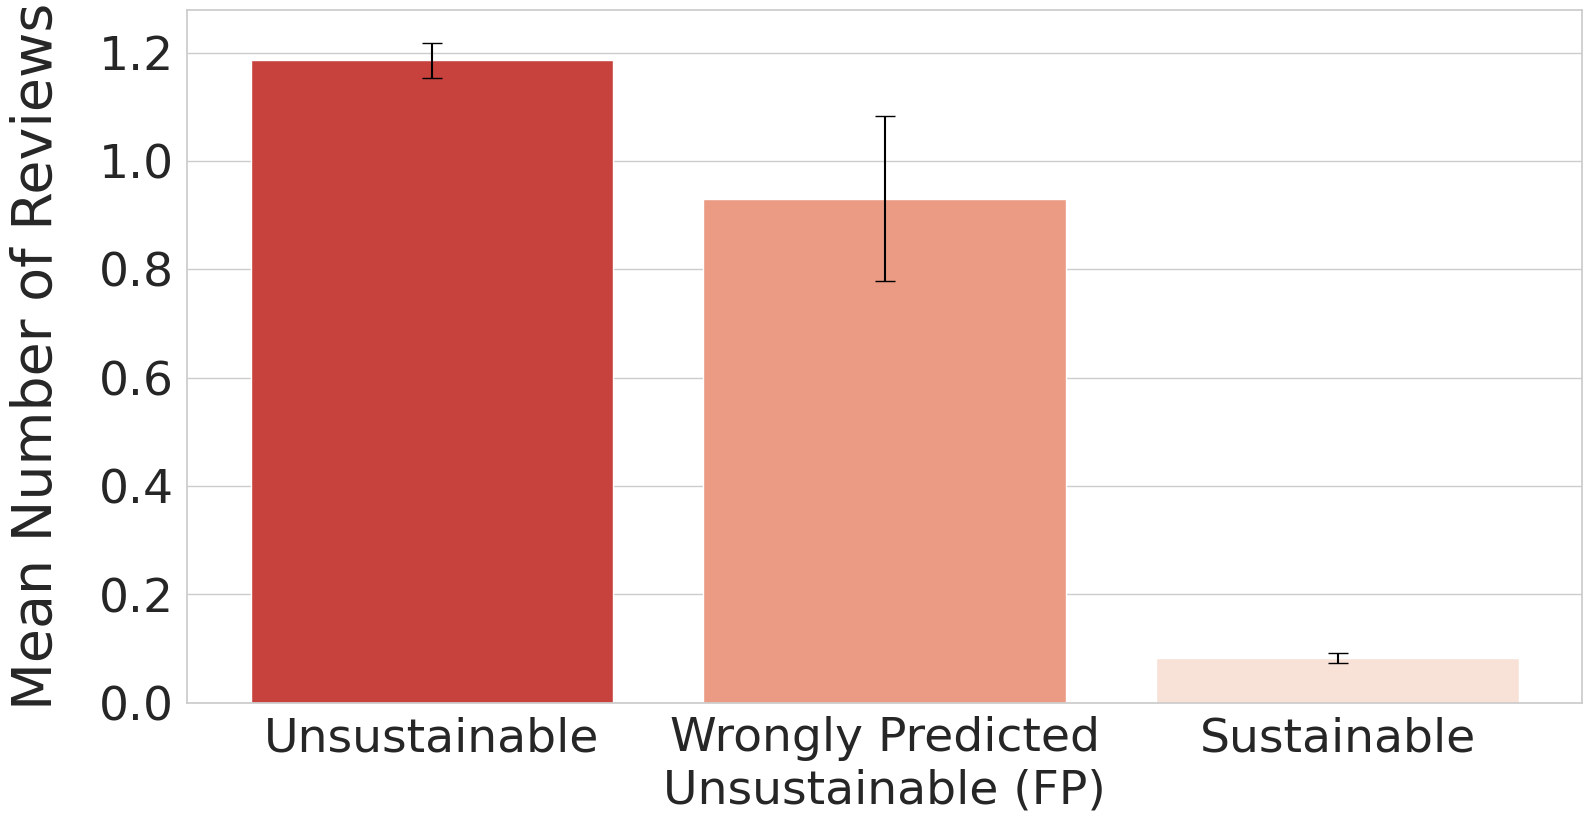

In [35]:
#columns_to_plot = ['Suspected Unsustainable (FN)', 'Suspected Sustainable (FP)', 'Well Predicted Unsustainable (TN)', 'Well Predicted Sustainable (TP)', 'All Population']
columns_to_plot = ['Unsustainable', 'Wrongly Predicted Unsustainable (FP)', 'Sustainable']
color_bars = True
save_fig = True
sns.set(style='whitegrid')
plt.figure(figsize=(18,9))
data_for_plot = {
    'category': ['Unsustainable', 'Sustainable', 'Wrongly Predicted Unsustainable (FP)', 'False Pos. (FP)',
                 'True Neg. (TN)', 'True Pos. (TP)', 'All'],
    'mean': [negative_pages_mean, positive_pages_mean, false_negatives_mean, false_positives_mean, 
             true_negatives_mean, true_positives_mean, all_population_mean],    # The mean values for each category
    'sd': [negative_pages_std, positive_pages_std, false_negatives_std, false_positives_std, 
             true_negatives_std, true_positives_std, all_population_std],    # The std values for each category
    'count': [negative_pages_n, positive_pages_n, false_negatives_n, false_positives_n, 
             true_negatives_n, true_positives_n, all_population_n],    # The std values for each category
}

# Create a DataFrame from the data 
data_for_plot_df = pd.DataFrame(data_for_plot)
data_for_plot_df = data_for_plot_df[data_for_plot_df['category'].isin(columns_to_plot)].copy()

# sorting the df according to my needs (so bars will appear in the desired order)
data_for_plot_df['category'] = pd.Categorical(data_for_plot_df['category'], categories=columns_to_plot, ordered=True)
data_for_plot_df = data_for_plot_df.sort_values('category')
# Calculate 95% confidence intervals
data_for_plot_df['ci'] = 1.96 * data_for_plot_df['sd'] / np.sqrt(data_for_plot_df['count'])

# Use the positions of the bars in the plot
x_positions = np.arange(len(data_for_plot_df))
# Create a bar plot where Seaborn and sorting the columns by the order I earlier defined
if color_bars:
    colors = ['#de2d26', '#fc9272', '#fee0d2']
    ax = sns.barplot(x='category', y='mean', data=data_for_plot_df, order=columns_to_plot, palette=colors, hue='category')
else:
    ax = sns.barplot(x='category', y='mean', data=data_for_plot_df, order=columns_to_plot)

plt.errorbar(x=x_positions, y=data_for_plot_df['mean'],
             yerr=data_for_plot_df['ci'], fmt='none', capsize=7, color='black')

# Adjust the x-axis labels after plotting
ax.set_xticklabels(['Unsustainable', 'Wrongly Predicted\nUnsustainable (FP)', 'Sustainable'])

# Set plot labels
plt.ylabel('Mean Number of Reviews', fontsize=40, labelpad = 25)
plt.yticks(fontsize=34)
plt.xticks(fontsize=34)
plt.xlabel('', fontsize=36)
# if required to save the fig
saving_file_name = usecase + '_error_analysis_based_reviews' + '.pdf'
if save_fig:
    plt.savefig(opj(model_folder, 'models_analysis', saving_file_name), format="pdf", bbox_inches="tight", dpi=1200)
plt.show()